In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed, dump
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dl_process import future_label

In [34]:
# 参数设定
threshold = 20
window = 30
slide = 1
valid_ratio = 0.2 # 用于验证的数据比例，数据太少的窗口会被丢弃
degree = 5
k = 12

# 数据加载与预处理
data = pd.read_csv("dataset.csv")
data = data[data['isError'] == 0]
data['type'], type_mapping = pd.factorize(data['type'])
mask = data['type'] == 1
data['to'] = np.where(mask, data['contractAddress'], data['to'])
data = data.drop(columns=['type', 'contractAddress'])
#按照blockNumber和to进行分组，即每个区块每个合约被调用次数，以区块为最小粒度
data = data.groupby(['blockNumber', 'to']).agg(
    counts=('gas', 'size'),
    gas_mean=('gas', 'mean'),
    gasUsed_mean=('gasUsed', 'mean'),
).reset_index()
#再按照合约地址进行分组
sum_data = data.groupby(['to']).agg({'counts': 'sum'}).reset_index()
print(len(sum_data))

# 筛选出调用次数大
filtered_data = data[data['to'].isin(sum_data[sum_data['counts'] > threshold]['to'])]
print(len(filtered_data))

split_idx1 = int(0.8 * len(filtered_data))
group_train_data = filtered_data[:split_idx1]
group_test_data = filtered_data[split_idx1:]

group_train_data = group_train_data.groupby(['to'])
group_test_data = group_test_data.groupby(['to'])
print(len(group_train_data))

192022
283234
917


In [35]:
def fit_per_window(group):
    blocks = group['blockNumber'].values.astype(int)
    counts = group['counts'].values
    gasUsed = group['gasUsed_mean'].values
    
    
    n_blocks = len(blocks)
    combined = []
    y_test = []
    
    i = 0
    while i < n_blocks - window + 1:
        # 当前窗口的起始块和结束块
        start_block = blocks[i]
        end_block = start_block + window
        
         # 使用二分查找确定窗口结束位置
        j = np.searchsorted(blocks, end_block, side='right')

        # 找到窗口内的所有区块（包括有交易的）
        window_mask = (blocks >= start_block) & (blocks < end_block)
        window_blocks = blocks[window_mask]
        window_counts = counts[window_mask]
        window_gasUsed_mean = np.mean(gasUsed[window_mask])
        window_gasUsed_std = np.std(gasUsed[window_mask])
       

        # 创建全零数组并填充实际存在的交易次数
        full_counts = np.zeros(window)
        # 计算相对坐标，将实际存在的交易次数填充到对应的位置
        existing_indices = window_blocks - start_block
        full_counts[existing_indices] = window_counts

        # 有效性检查，如果窗口内交易次数占比低于阈值，则跳过该窗口
        valid_ratio_actual = np.sum(full_counts > 0) / window
        if valid_ratio_actual < valid_ratio:
            # 寻找下一个有效起始点
            next_block_idx = j  # 默认跳到当前窗口结束位置
            if j < n_blocks:
                # 计算下一个可能有效的位置：下一个区块的前window个位置
                next_valid_start = max(blocks[j] - window + 1, start_block + 1)
                next_block_idx = np.searchsorted(blocks, next_valid_start, side='left')
            
            i = next_block_idx
            continue

        try:
            # 使用相对时间偏移
            x = np.arange(window) + 1
            y = full_counts
            model = np.polyfit(x, y, degree)
            combined_features = np.concatenate([
                model,
                [
                    window_gasUsed_mean,
                    window_gasUsed_std,
                    valid_ratio_actual
                ]
                   ])    
            combined.append(combined_features)
            # 生成测试集
            label = np.zeros(future_label)
            label_mask = (blocks >= end_block) & (blocks < end_block + future_label)
            label_indices = blocks[label_mask] - end_block
            label[label_indices] = counts[label_mask]
            y_test.append(label)
        except Exception as e:
            print(f"Error : {e}")
            pass
        
        # 动态步长调整：至少滑动1个区块
        i += max(slide, 1)
    
    return combined, y_test

# 并行处理所有合约
create_train = Parallel(n_jobs=-1)(
    delayed(fit_per_window)(group) for _, group in tqdm(group_train_data, desc='Train')
)

create_test = Parallel(n_jobs=-1)(
    delayed(fit_per_window)(group) for _, group in tqdm(group_test_data, desc='Test')
)

# 收集所有窗口的拟合参数
train_combined, y_train = [], []
X_test, y_test  = [], []

for train in create_train:
    train_combined.extend(train[0])
    y_train.extend(train[1])
for test in create_test:
    X_test.extend(test[0])
    y_test.extend(test[1])

Test: 100%|██████████| 869/869 [00:01<00:00, 728.72it/s]


127779
(127779, 9) (127779, 6)


c:\Users\11845\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\11845\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


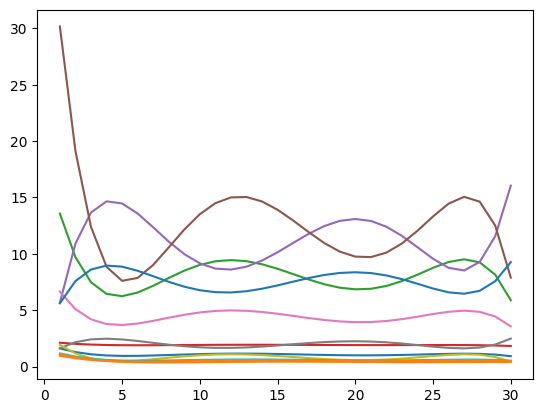

In [36]:
# 转换为NumPy数组
print(len(train_combined))
fit = np.array(train_combined)
fit_compare = np.array(train_combined)[:, 0:degree+1]
print(fit.shape, fit_compare.shape)
X_test = np.array(X_test)
X_test_compare = np.array(X_test)[:, 0:degree+1]
y_train = np.array(y_train)
y_test = np.array(y_test)
# # 预处理
scaler = StandardScaler()
fit_scaled = scaler.fit_transform(fit)

scaler_compare = StandardScaler()
fit_compare_scaled = scaler_compare.fit_transform(fit_compare)  
# 聚类
kmeans = KMeans(n_clusters=k).fit(fit_scaled)
kmeans_compare = KMeans(n_clusters=k).fit(fit_compare_scaled)
# # 反标准化
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_compare = scaler_compare.inverse_transform(kmeans_compare.cluster_centers_)
# 画出曲线
x = np.arange(window) + 1
y = np.zeros((k, len(x)))
for i in range(k):
    for j in range(degree + 1):
        y[i] += cluster_centers[i][j] * (x ** (degree - j))

plt.figure()
for i in range(k):
    plt.plot(x, y[i], label=f'cluster {i}')

def evaluate_predictions(y_true, y_pred):
    # 展平维度计算整体指标
    flat_true = y_true.flatten()
    flat_pred = y_pred.flatten()

    # 平均绝对误差和均方误差
    print(f"Overall MAE: {mean_absolute_error(flat_true, flat_pred):.2f}")
    print(f"Overall MSE: {mean_squared_error(flat_true, flat_pred):.2f}")

    # 分步长计算指标
    for step in range(future_label):
        step_mae = mean_absolute_error(y_true[:, step], y_pred[:, step])
        step_mse = mean_squared_error(y_true[:, step], y_pred[:, step])
        print(f"Step {step + 1} MAE: {step_mae:.2f}, MSE: {step_mse:.2f}")

# dump(scaler, 'cluster_scaler.joblib')
# dump(kmeans, 'cluster_model.joblib')


In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

X_test = scaler.transform(X_test)
y_pred_label = kmeans.predict(X_test)

# 对每个聚类单独训练GBDT模型
cluster_models = {}
for cluster_id in range(k):
    # 获取当前聚类的训练数据
    mask = kmeans.labels_ == cluster_id
    X_cluster = fit_scaled[mask]
    y_cluster = y_train[mask]  # 需要提前准备对应的训练标签
    
    # 训练回归模型
    model = MultiOutputRegressor(
        GradientBoostingRegressor(n_estimators=100, random_state=42)
    )
    model.fit(X_cluster, y_cluster)
    cluster_models[cluster_id] = model

30 5
Overall MAE: 1.24
Overall MSE: 7.51
Step 1 MAE: 1.24, MSE: 7.44
Step 2 MAE: 1.24, MSE: 7.53
Step 3 MAE: 1.25, MSE: 7.59
Step 4 MAE: 1.24, MSE: 7.54
Step 5 MAE: 1.24, MSE: 7.45
Overall MAE: 1.56
Overall MSE: 10.65
Step 1 MAE: 1.56, MSE: 10.50
Step 2 MAE: 1.56, MSE: 10.52
Step 3 MAE: 1.57, MSE: 10.76
Step 4 MAE: 1.53, MSE: 10.52
Step 5 MAE: 1.56, MSE: 10.96
Overall MAE: 1.56
Overall MSE: 10.19
Step 1 MAE: 1.56, MSE: 10.00
Step 2 MAE: 1.56, MSE: 10.12
Step 3 MAE: 1.58, MSE: 10.18
Step 4 MAE: 1.54, MSE: 10.05
Step 5 MAE: 1.56, MSE: 10.60


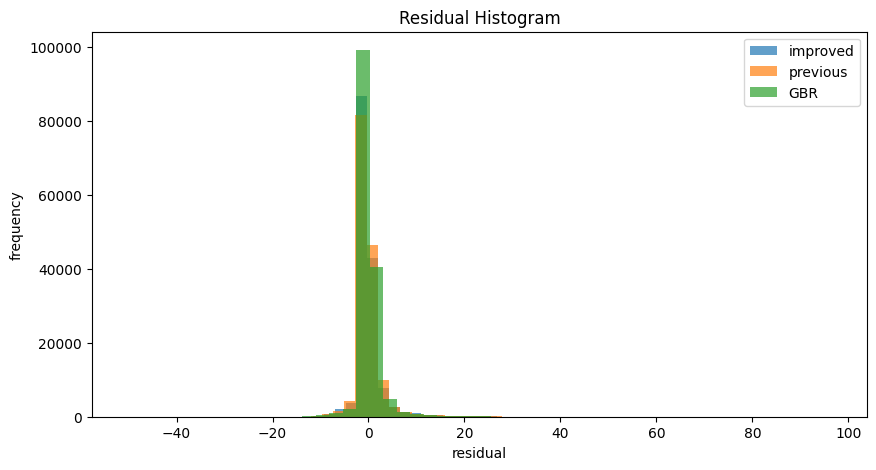

In [38]:
X_test_compare = scaler_compare.transform(X_test_compare)
y_pred_label_compare = kmeans_compare.predict(X_test_compare)

#  预测
y_pred_GBR = np.zeros((len(y_test), future_label))
for i in range(len(y_test)):
    cluster_id = y_pred_label[i]
    features = X_test[i].reshape(1, -1)
    y_pred_GBR[i] = cluster_models[cluster_id].predict(features)

y_pred = np.zeros((len(y_test), future_label))
for i in range(len(y_test)):
    for j in range(future_label):
        future_step = window + j + 1 - future_label
        for z in range(degree + 1):
            y_pred[i][j] += cluster_centers[y_pred_label[i]][z] * (future_step ** (degree - z))

y_pred_compare = np.zeros((len(y_test), future_label))
for i in range(len(y_test)):
    for j in range(future_label):
        future_step = window + j + 1 - future_label
        for z in range(degree + 1):
            y_pred_compare[i][j] += cluster_centers_compare[y_pred_label_compare[i]][z] * (future_step ** (degree - z))

print(window, degree)
evaluate_predictions(y_test, y_pred_GBR)
evaluate_predictions(y_test, y_pred)
evaluate_predictions(y_test, y_pred_compare)
plt.figure(figsize=(10, 5))
plt.hist(y_test.flatten() - y_pred.flatten(), bins=50, alpha=0.7, label='improved')
plt.hist(y_test.flatten() - y_pred_compare.flatten(), bins=50, alpha=0.7, label='previous')
plt.hist(y_test.flatten() - y_pred_GBR.flatten(), bins=50, alpha=0.7, label='GBR')
plt.title('Residual Histogram')
plt.xlabel('residual')
plt.ylabel('frequency')
plt.title('Residual Histogram')
plt.legend()
plt.show()

In [39]:
# max_k = 40
# inertia = []

# # 遍历k值范围计算SSE
# for k in range(1, max_k+1):
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(fit)
#     inertia.append(kmeans.inertia_)  # 获取SSE


In [40]:
# # 绘制肘部曲线
# plt.figure(figsize=(12,6))
# plt.plot(np.arange(1, max_k+1), inertia, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia (SSE)')
# plt.title('Elbow Method')
# plt.xticks(np.arange(1, max_k+1))
# plt.grid(True)
# plt.show()
